In [34]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torch.optim as optim
from torch.utils.data import random_split
from torchvision.datasets import DatasetFolder

In [35]:
torch.cuda.set_device(0)
device = torch.device("cuda")
torch.cuda.is_available()

True

In [36]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

In [92]:
trainset = ImageFolder("trafic_32/", transform=transform)

train_size = int(0.8 * len(trainset))
test_size = len(trainset) - train_size

# Podział trainset na zbiory treningowy i testowy
train_dataset, test_dataset = random_split(trainset, [train_size, test_size])

# Utworzenie DataLoader dla każdego zbioru danych
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                            shuffle=True, num_workers=16)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                           shuffle=False, num_workers=16)


classes = trainset.classes



/home/natalia/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [127]:
def get_train_images(num):
    inverse_transform = transforms.Compose([
    transforms.Normalize(mean=(-0.5 / 0.5), std=(1 / 0.5)),
    transforms.Normalize(mean=(-0.5, -0.5, -0.5), std=(1, 1, 1))
])
    return torch.stack([inverse_transform(test_dataset[i][0]) for i in range(10, 10 + num)], dim=0)

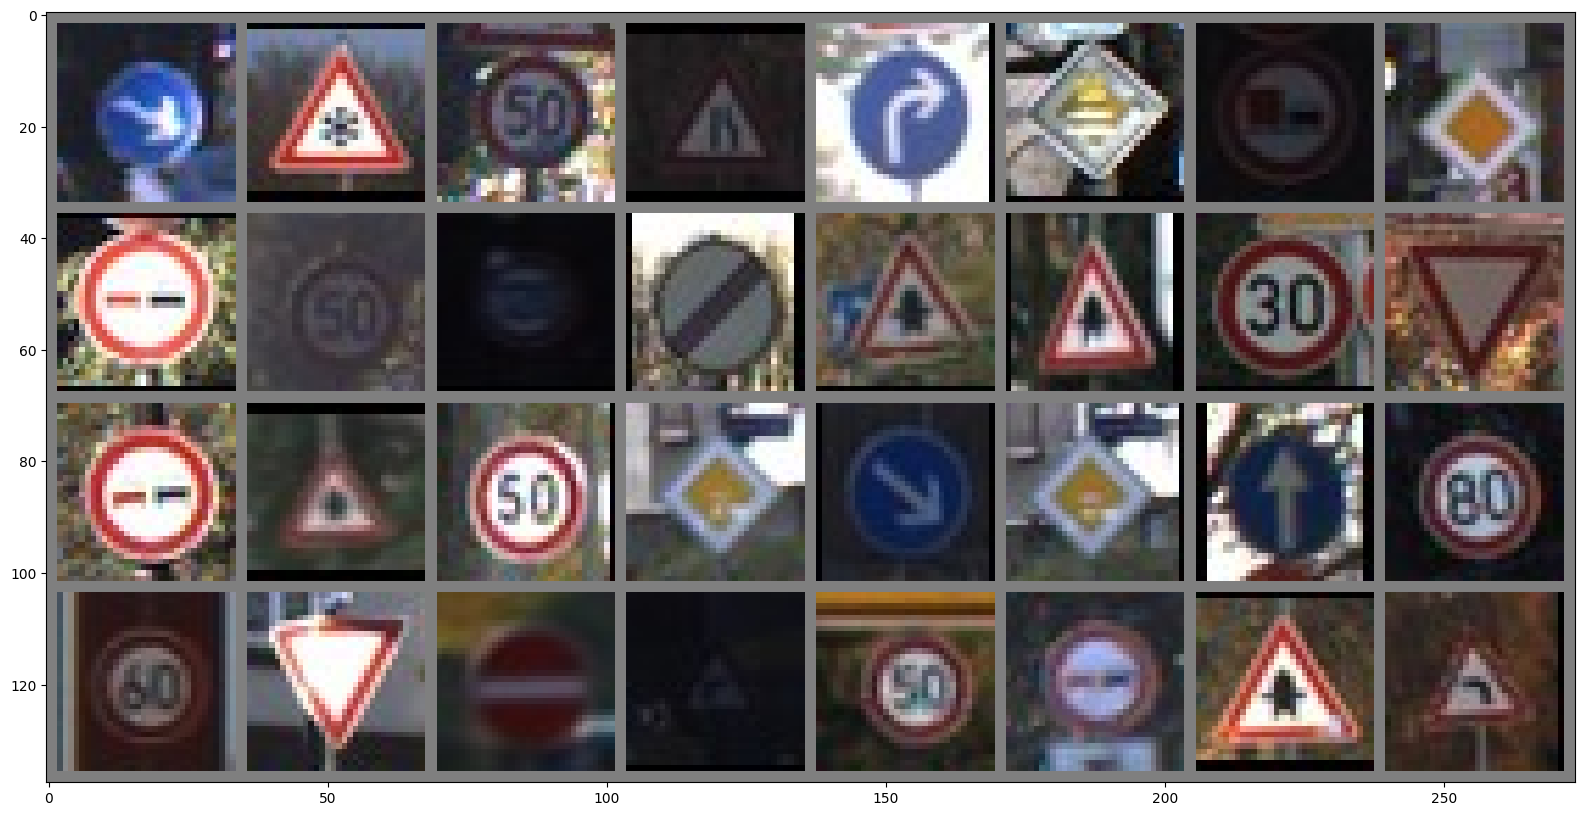

00038 00030 00002 00024 00033 00012 00010 00012 00009 00002 00008 00032 00011 00011 00001 00013 00009 00011 00002 00012 00038 00012 00035 00005 00003 00013 00017 00020 00002 00009 00011 00019


In [94]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (20,10))


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
images, labels = next(iter(train_loader))

# show images
imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [95]:
images, labels = next(iter(train_loader))
images[0:1].size()

torch.Size([1, 3, 32, 32])

In [97]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean  = nn.Linear(hidden_dim, latent_dim)
        self.fc_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x       = self.LeakyReLU(self.fc_1(x))
        x       = self.LeakyReLU(self.fc_2(x))
        mean     = self.fc_mean(x)
        log_var  = self.fc_var(x)                      # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

In [98]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.fc_1(x))
        h     = self.LeakyReLU(self.fc_2(h))
        
        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, 3, 32, 32])
        return x_hat
        

In [99]:
class VAE(nn.Module):
    def __init__(self, x_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

        
    def reparameterization(self, mean, var):
        # Change to proper sampling
        # z = mean
        # z = tprch.normal(mean,var)
        z = torch.randn_like(mean)*var+mean
        return z
        
                
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat = self.decoder(z)
        return x_hat, mean, log_var

In [100]:
vae = VAE(latent_dim=16, hidden_dim=256, x_dim=3*32*32).to(device)
input_imgs = get_train_images(8)

In [101]:
def vae_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD      = -0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [102]:
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [103]:
def generate_images(model, n_imgs, device):
    # Generate images
    model.eval()
    with torch.no_grad():
        generated_imgs = model.decoder(torch.randn([n_imgs, model.latent_dim]).to(device))
    generated_imgs = generated_imgs.cpu()
    
    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=False)
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

In [104]:


num_epochs = 30
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(train_loader):
        x = x.to(device)
        out, means, log_var = vae(x)
        loss = vae_loss_function(x, out, means, log_var) 
        losses_epoch.append(loss.item())
        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()  
    L1_list = []
#     if n % 10 == 0:
    for x, _ in iter(test_loader):
        x  = x.to(device)
        out, _, _ = vae(x)
        L1_list.append(torch.mean(torch.abs(out-x)).item())
    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

Epoch 0 loss 41373.684327416224, test L1 = 0.5617431861356021
Epoch 1 loss 39348.22405987194, test L1 = 0.5559930445217505
Epoch 2 loss 38959.24793139972, test L1 = 0.5513727190048714
Epoch 3 loss 38723.75490570846, test L1 = 0.5499129225083483
Epoch 4 loss 38570.51791658703, test L1 = 0.5497346255110531
Epoch 5 loss 38479.933868999266, test L1 = 0.5460138696480573
Epoch 6 loss 38396.60496951851, test L1 = 0.5459789909967562
Epoch 7 loss 38348.294739205056, test L1 = 0.5454001291011407
Epoch 8 loss 38295.95384771598, test L1 = 0.5464689368154945
Epoch 9 loss 38250.7213103657, test L1 = 0.5447933295877968


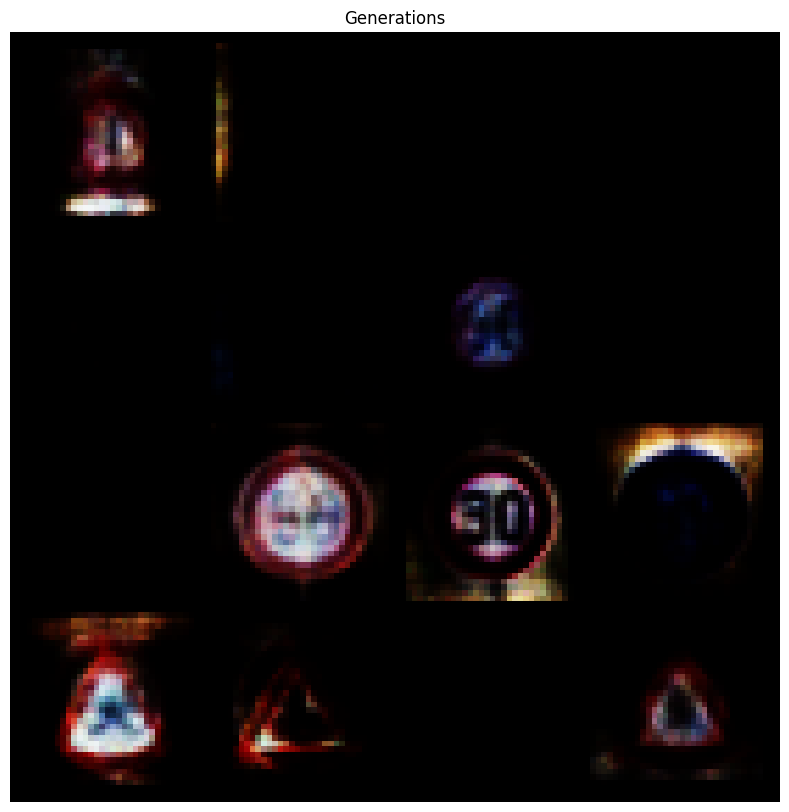

In [120]:
generate_images(vae, 16 , device)

In [121]:
def visualize_reconstructions(model, input_imgs, device):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs, means, log_var = model(input_imgs.to(device))
    reconst_imgs = reconst_imgs.cpu()
    
    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=False)
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Reconstructions")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


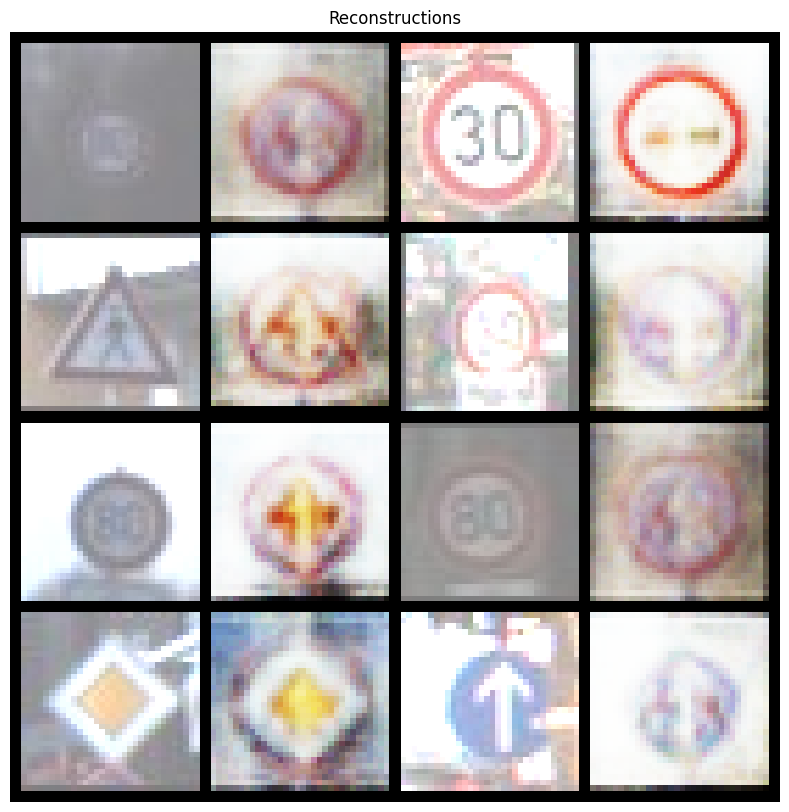

In [126]:
input_imgs = get_train_images(8)
visualize_reconstructions(vae, input_imgs, device)

In [27]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out  = nn.Linear(hidden_dim, 1)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        x = self.fc_out(x)
        return x

In [28]:
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.fc_1(x))
        h     = self.LeakyReLU(self.fc_2(h))
        
        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, 3, 32, 32])
        return x_hat

In [29]:
# Models
latent_dim = 32
generator = Generator(latent_dim=latent_dim, hidden_dim=256, output_dim=3*32*32).to(device)
discriminator = Discriminator( hidden_dim=256, input_dim=3*32*32).to(device)

# Optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
generator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=generator_optimizer, gamma=0.99)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
discriminator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=discriminator_optimizer, gamma=0.99)

# loss
criterion = nn.MSELoss()

In [30]:
fixed_noise = torch.randn(16, latent_dim,device=device)

Epoch: 0, discrimiantor fake error: 0.00934, discriminator real acc: 0.975


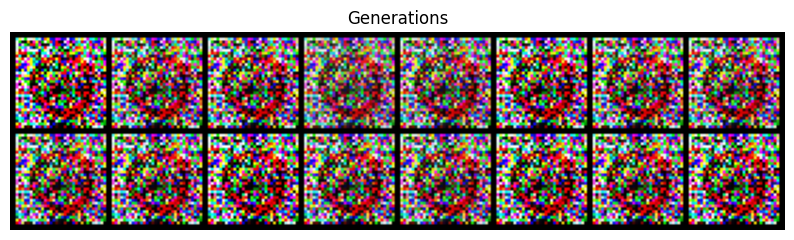

Epoch: 1, discrimiantor fake error: 0.00302, discriminator real acc: 0.992
Epoch: 2, discrimiantor fake error: 0.00294, discriminator real acc: 0.994
Epoch: 3, discrimiantor fake error: 0.00388, discriminator real acc: 0.996
Epoch: 4, discrimiantor fake error: 0.00554, discriminator real acc: 0.996
Epoch: 5, discrimiantor fake error: 0.00756, discriminator real acc: 0.995
Epoch: 6, discrimiantor fake error: 0.0054, discriminator real acc: 0.995
Epoch: 7, discrimiantor fake error: 0.00499, discriminator real acc: 0.995
Epoch: 8, discrimiantor fake error: 0.00488, discriminator real acc: 0.995
Epoch: 9, discrimiantor fake error: 0.00444, discriminator real acc: 0.996
Epoch: 10, discrimiantor fake error: 0.00461, discriminator real acc: 0.996


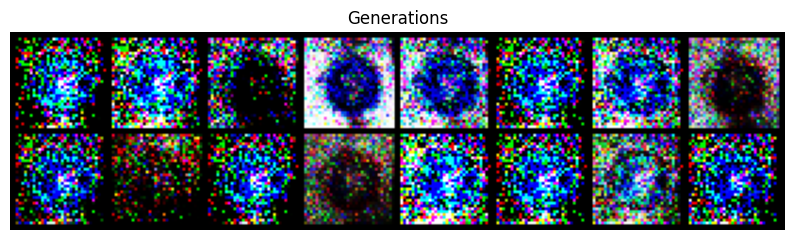

Epoch: 11, discrimiantor fake error: 0.00388, discriminator real acc: 0.996
Epoch: 12, discrimiantor fake error: 0.00395, discriminator real acc: 0.996
Epoch: 13, discrimiantor fake error: 0.00366, discriminator real acc: 0.997
Epoch: 14, discrimiantor fake error: 0.00385, discriminator real acc: 0.996
Epoch: 15, discrimiantor fake error: 0.00395, discriminator real acc: 0.996
Epoch: 16, discrimiantor fake error: 0.00369, discriminator real acc: 0.997
Epoch: 17, discrimiantor fake error: 0.00389, discriminator real acc: 0.997
Epoch: 18, discrimiantor fake error: 0.00374, discriminator real acc: 0.997
Epoch: 19, discrimiantor fake error: 0.00368, discriminator real acc: 0.997
Epoch: 20, discrimiantor fake error: 0.00363, discriminator real acc: 0.997


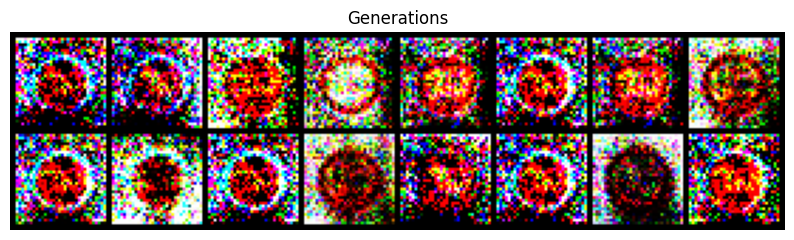

Epoch: 21, discrimiantor fake error: 0.00367, discriminator real acc: 0.997
Epoch: 22, discrimiantor fake error: 0.00404, discriminator real acc: 0.996
Epoch: 23, discrimiantor fake error: 0.00386, discriminator real acc: 0.996
Epoch: 24, discrimiantor fake error: 0.0038, discriminator real acc: 0.997
Epoch: 25, discrimiantor fake error: 0.00401, discriminator real acc: 0.996
Epoch: 26, discrimiantor fake error: 0.00445, discriminator real acc: 0.996
Epoch: 27, discrimiantor fake error: 0.00463, discriminator real acc: 0.996
Epoch: 28, discrimiantor fake error: 0.00417, discriminator real acc: 0.996
Epoch: 29, discrimiantor fake error: 0.00371, discriminator real acc: 0.996
Epoch: 30, discrimiantor fake error: 0.00381, discriminator real acc: 0.996


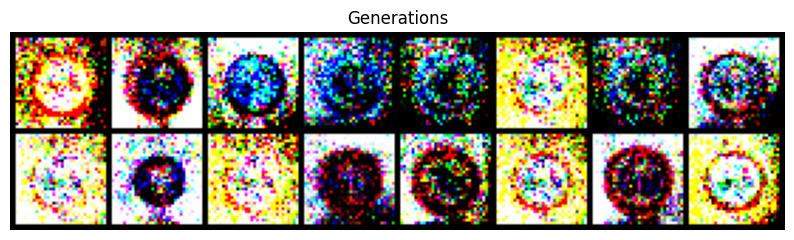

Epoch: 31, discrimiantor fake error: 0.00407, discriminator real acc: 0.996
Epoch: 32, discrimiantor fake error: 0.00412, discriminator real acc: 0.996
Epoch: 33, discrimiantor fake error: 0.00333, discriminator real acc: 0.997
Epoch: 34, discrimiantor fake error: 0.00319, discriminator real acc: 0.997
Epoch: 35, discrimiantor fake error: 0.00308, discriminator real acc: 0.997
Epoch: 36, discrimiantor fake error: 0.00311, discriminator real acc: 0.997
Epoch: 37, discrimiantor fake error: 0.00295, discriminator real acc: 0.997
Epoch: 38, discrimiantor fake error: 0.003, discriminator real acc: 0.997
Epoch: 39, discrimiantor fake error: 0.00261, discriminator real acc: 0.997
Epoch: 40, discrimiantor fake error: 0.00254, discriminator real acc: 0.997


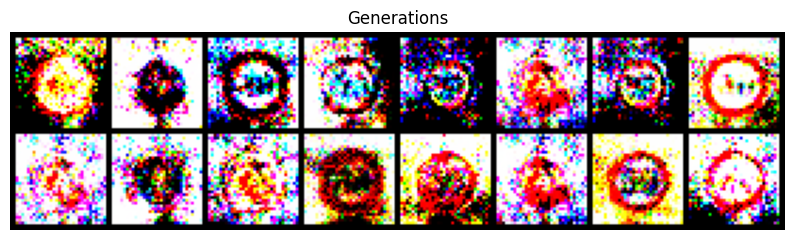

Epoch: 41, discrimiantor fake error: 0.00293, discriminator real acc: 0.997
Epoch: 42, discrimiantor fake error: 0.00246, discriminator real acc: 0.998
Epoch: 43, discrimiantor fake error: 0.00242, discriminator real acc: 0.998
Epoch: 44, discrimiantor fake error: 0.00261, discriminator real acc: 0.997
Epoch: 45, discrimiantor fake error: 0.0025, discriminator real acc: 0.997
Epoch: 46, discrimiantor fake error: 0.00226, discriminator real acc: 0.998
Epoch: 47, discrimiantor fake error: 0.00243, discriminator real acc: 0.998
Epoch: 48, discrimiantor fake error: 0.00238, discriminator real acc: 0.998
Epoch: 49, discrimiantor fake error: 0.00222, discriminator real acc: 0.998
Epoch: 50, discrimiantor fake error: 0.00238, discriminator real acc: 0.998


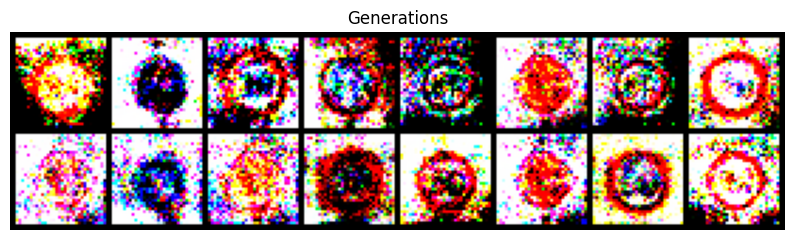

Epoch: 51, discrimiantor fake error: 0.00214, discriminator real acc: 0.998
Epoch: 52, discrimiantor fake error: 0.00204, discriminator real acc: 0.998
Epoch: 53, discrimiantor fake error: 0.00225, discriminator real acc: 0.998
Epoch: 54, discrimiantor fake error: 0.00204, discriminator real acc: 0.998
Epoch: 55, discrimiantor fake error: 0.00203, discriminator real acc: 0.998
Epoch: 56, discrimiantor fake error: 0.00222, discriminator real acc: 0.998
Epoch: 57, discrimiantor fake error: 0.0021, discriminator real acc: 0.998
Epoch: 58, discrimiantor fake error: 0.00226, discriminator real acc: 0.998
Epoch: 59, discrimiantor fake error: 0.00194, discriminator real acc: 0.998
Epoch: 60, discrimiantor fake error: 0.00193, discriminator real acc: 0.998


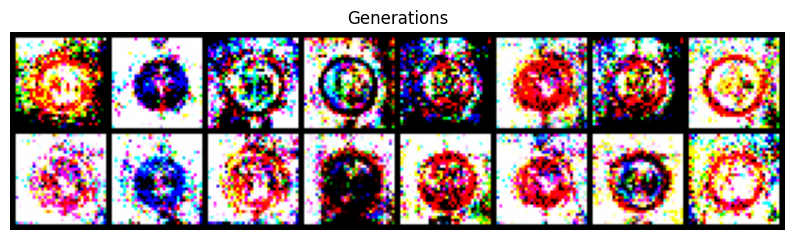

Epoch: 61, discrimiantor fake error: 0.00188, discriminator real acc: 0.998
Epoch: 62, discrimiantor fake error: 0.00166, discriminator real acc: 0.998
Epoch: 63, discrimiantor fake error: 0.00168, discriminator real acc: 0.998
Epoch: 64, discrimiantor fake error: 0.00193, discriminator real acc: 0.998
Epoch: 65, discrimiantor fake error: 0.0018, discriminator real acc: 0.998
Epoch: 66, discrimiantor fake error: 0.00178, discriminator real acc: 0.998
Epoch: 67, discrimiantor fake error: 0.00171, discriminator real acc: 0.998
Epoch: 68, discrimiantor fake error: 0.0018, discriminator real acc: 0.998
Epoch: 69, discrimiantor fake error: 0.00179, discriminator real acc: 0.998
Epoch: 70, discrimiantor fake error: 0.00179, discriminator real acc: 0.998


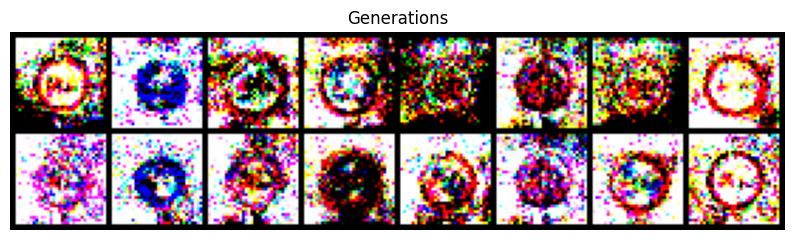

Epoch: 71, discrimiantor fake error: 0.00164, discriminator real acc: 0.998
Epoch: 72, discrimiantor fake error: 0.00164, discriminator real acc: 0.998
Epoch: 73, discrimiantor fake error: 0.00167, discriminator real acc: 0.998
Epoch: 74, discrimiantor fake error: 0.00161, discriminator real acc: 0.998
Epoch: 75, discrimiantor fake error: 0.00154, discriminator real acc: 0.998
Epoch: 76, discrimiantor fake error: 0.00165, discriminator real acc: 0.998
Epoch: 77, discrimiantor fake error: 0.0017, discriminator real acc: 0.998
Epoch: 78, discrimiantor fake error: 0.00178, discriminator real acc: 0.998
Epoch: 79, discrimiantor fake error: 0.0016, discriminator real acc: 0.998
Epoch: 80, discrimiantor fake error: 0.0016, discriminator real acc: 0.998


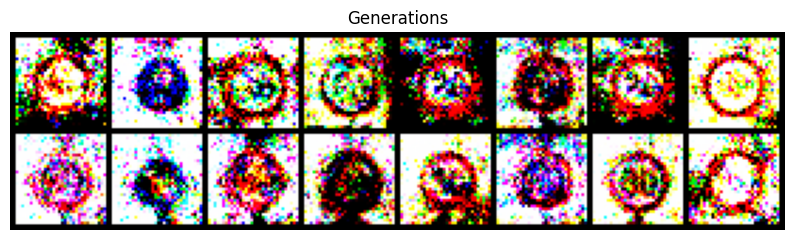

Epoch: 81, discrimiantor fake error: 0.00161, discriminator real acc: 0.998
Epoch: 82, discrimiantor fake error: 0.00149, discriminator real acc: 0.998
Epoch: 83, discrimiantor fake error: 0.00138, discriminator real acc: 0.999
Epoch: 84, discrimiantor fake error: 0.00135, discriminator real acc: 0.999
Epoch: 85, discrimiantor fake error: 0.00136, discriminator real acc: 0.999
Epoch: 86, discrimiantor fake error: 0.00141, discriminator real acc: 0.999
Epoch: 87, discrimiantor fake error: 0.00131, discriminator real acc: 0.999
Epoch: 88, discrimiantor fake error: 0.00134, discriminator real acc: 0.999
Epoch: 89, discrimiantor fake error: 0.00136, discriminator real acc: 0.999
Epoch: 90, discrimiantor fake error: 0.00108, discriminator real acc: 0.999


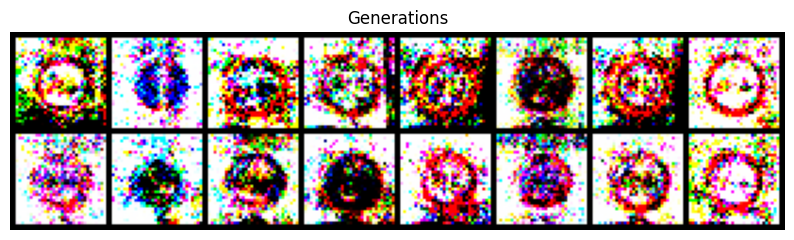

Epoch: 91, discrimiantor fake error: 0.00116, discriminator real acc: 0.999
Epoch: 92, discrimiantor fake error: 0.0011, discriminator real acc: 0.999
Epoch: 93, discrimiantor fake error: 0.00103, discriminator real acc: 0.999
Epoch: 94, discrimiantor fake error: 0.00101, discriminator real acc: 0.999
Epoch: 95, discrimiantor fake error: 0.000931, discriminator real acc: 0.999
Epoch: 96, discrimiantor fake error: 0.000942, discriminator real acc: 0.999
Epoch: 97, discrimiantor fake error: 0.00095, discriminator real acc: 0.999
Epoch: 98, discrimiantor fake error: 0.000939, discriminator real acc: 0.999
Epoch: 99, discrimiantor fake error: 0.00088, discriminator real acc: 0.999


In [31]:
G_losses = []
D_losses = []
num_epochs = 100
for epoch in range(num_epochs):
    # For each batch in the dataloader
    discriminator_fake_acc = []
    discriminator_real_acc = []
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator_optimizer.zero_grad()
        # Format batch
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.ones((b_size,), dtype=torch.float, device=device) # Setting labels for real images
        # Forward pass real batch through D
        output = discriminator(real_images).view(-1)
        # Calculate loss on all-real batch
        error_discriminator_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        discriminator_real_acc.append(output.mean().item())

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_dim,device=device)
        # Generate fake image batch with Generator
        fake_images = generator(noise)
        label_fake = torch.zeros((b_size,), dtype=torch.float, device=device)
        # Classify all fake batch with Discriminator
        output = discriminator(fake_images.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        error_discriminator_fake = criterion(output, label_fake)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        discriminator_fake_acc.append(output.mean().item())
        # Compute error of D as sum over the fake and the real batches
        error_discriminator = error_discriminator_real + error_discriminator_fake
        error_discriminator.backward()
        # Update D
        discriminator_optimizer.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator_optimizer.zero_grad()
        label = torch.ones((b_size,), dtype=torch.float, device=device)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake_images).view(-1)
        # Calculate G's loss based on this output
        error_generator = criterion(output, label)
        # Calculate gradients for G
        error_generator.backward()
        D_G_z2 = output.mean().item()
        # Update G
        generator_optimizer.step()

        # Output training stats
        # Save Losses for plotting later
        G_losses.append(error_generator.item())
        D_losses.append(error_discriminator.item())

    print(f"Epoch: {epoch}, discrimiantor fake error: {np.mean(discriminator_fake_acc):.3}, discriminator real acc: {np.mean(discriminator_real_acc):.3}")
    generator_scheduler.step()
    discriminator_scheduler.step()
    if epoch % 10 == 0:
        with torch.no_grad():
            fake = generator(fixed_noise).detach().cpu()
        grid = torchvision.utils.make_grid(fake)
        grid = grid.permute(1, 2, 0)
        plt.figure(figsize=(10,10))
        plt.title(f"Generations")
        plt.imshow(grid)
        plt.axis('off')
        plt.show()

In [32]:
torch.save(generated_imgs.cpu().detach(),"poniedzialek_nazwisko1_nazwisko2.pt")

NameError: name 'generated_imgs' is not defined